<a href="https://colab.research.google.com/github/syedareehaquasar/SBSPS-Challenge-4482-Sentiment-Analysis-of-COVID-19-tweets/blob/master/sentimental_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
!pip install -q transformers==2.1.1
!pip install -q torch

In [12]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path 
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
import os

import torch
import torch.optim as optim

import random 

# fastai
from fastai import *
from fastai.text import *
from fastai.callbacks import *

# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig

#Sentiment Analyzer

In [13]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
            tokens = [CLS] + tokens + [SEP]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
            if self.model_type in ['xlnet']:
                tokens = tokens + [SEP] +  [CLS]
            else:
                tokens = [CLS] + tokens + [SEP]
        return tokens

In [14]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)
    
    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})

In [15]:
# defining our model architecture 
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
        
        # attention_mask
        # Mask to avoid performing attention on padding token indices.
        # Mask values selected in ``[0, 1]``:
        # ``1`` for tokens that are NOT MASKED, ``0`` for MASKED tokens.
        attention_mask = (input_ids!=pad_idx).type(input_ids.type()) 
        
        logits = self.transformer(input_ids,
                                  attention_mask = attention_mask)[0]   
        return logits

In [16]:
model_type = 'roberta'
pretrained_model_name = 'roberta-base'

model_class, tokenizer_class, config_class = RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig

transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

pad_idx = transformer_tokenizer.pad_token_id

In [17]:
path = '/content/drive/My Drive/IBM_hack2020/model'
learner = load_learner(path, 'transformer.pkl')

In [24]:
def predict_sentiment(text):
  sentiment = learner.predict(text)[1].item()
  return sentiment

def sentiment_label (Sentiment):
   if Sentiment == 2:
       return "positive"
   elif Sentiment == 0:
       return "negative"
   else :
       return "neutral"

In [25]:
DATA_ROOT = Path("..") / '/content/drive/My Drive/IBM_hack2020/Train.csv'
predictions_test = pd.read_csv(DATA_ROOT)

predictions_test['Prediction'] = predictions_test['full_text'].apply(predict_sentiment)
predictions_test['Prediction_text'] = predictions_test['Prediction'].apply(sentiment_label)
class_names = ['negative','positive','neutral']

In [26]:
predictions_test.head()

,id,full_text,retweet_count,Sentiment,Prediction,Prediction_text
0,1260158379936358400,Watch live tonight at 8 pm on LINK narendramod...,0,positive,2,positive
1,1269634025523642369,Enjoy piece of your own paradise Outdoorpool ...,0,positive,2,positive
2,1269117643312816128,Introduction to Security Operations Center SOC...,0,positive,2,positive
3,1267416133449273345,Lipsasingha3 AprilMay edition of लोककल्याणसेतु...,0,positive,0,negative
4,1267528967424270342,Dr Pankaj Shah aged 65\nM D Physician\nExpired...,1,negative,0,negative


In [27]:
print(classification_report(predictions_test['Sentiment'], predictions_test['Prediction_text'], target_names=class_names))

              precision    recall  f1-score   support

    negative       0.70      0.70      0.70       429
    positive       0.89      0.85      0.87      1031
     neutral       0.88      0.91      0.90      1710

    accuracy                           0.86      3170
   macro avg       0.83      0.82      0.82      3170
weighted avg       0.86      0.86      0.86      3170



In [28]:
cf = confusion_matrix(predictions_test['Sentiment'],predictions_test['Prediction_text'])

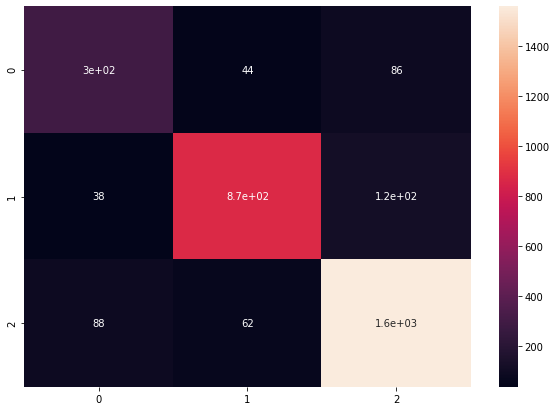

In [29]:
#Plotting the Confusion matrix using Seaborn Library
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


plt.figure(figsize = (10,7))
sn.heatmap(cf,annot=True)